# Analyzing Customer-Music Data using Apache Spark

The original Tableau based tutorial is at https://mapr.com/blog/real-time-user-profiles-spark-drill-and-mapr-db/. I have coverted them to Python and also configured to run the codes on Jupter Notebooks with Pyspark 2.2 and used the Jupyter Notebook to render visualization and added more stuffs.

Users are continuously connecting to the service and listening to tracks that they like -- this generates our main data set. The behaviors captured in these events, over time, represent the highest level of detail about actual behaviors of customers as they consume the service by listening to music. In addition to the events of listening to individual tracks, we have a few other data sets representing all the information we might normally have in such a service. In this post we will make use of the following two data sets, and in my next post we will bring in an additional data set relating to click events.

**How to Configure Jupter Notebook to run Spark 2.2:**
```
1. Create an Anaconda environment 'pyspark'
2. !pip install pyspark (this package will directly communicate with Spark)
3. Install Spark in your machine (from here: https://spark.apache.org/downloads.html). I installed spark-2.2.0-bin-hadoop2.6.tgz
4. In your .bash_profile set the following
    export SPARK_HOME=/Users/anindyas/work/spark-2.2.0-bin-hadoop2.6
    PATH=$SPARK_HOME/bin:$PATH
    export PATH

    export PATH="/Users/anindyas/anaconda/envs/pyspark/bin:$PATH"
    
    There is further better way to set the environment variables for anaconda but for now it is fine.
5. Switch to pyspark anaconda environment and start the jupyter notebook from that environment.
```

## 1. Understanding the Data Set

**Individual customers listening to individual tracks: (tracks.csv)** - a collection of events, one per line, where each event is a client listening to a track.

This data is approximately 1M lines and contains simulated listener events over several months.

<table>
  <tr>
    <th><strong>Field Name</strong></th>
    <th>Event ID</th>
    <th>Customer ID</th>
    <th>Track ID</th>
    <th>Datetime</th>
    <th>Mobile</th>
    <th>Listening Zip</th>
  </tr>
  <tr>
    <td><strong>Type</strong></td>
    <td>Integer</td>
    <td>Integer</td>
    <td>Integer</td>
    <td>String</td>
    <td>Integer</td>
    <td>Integer</td>
  </tr>
  <tr>
    <td><strong>Example Value</strong></td>
    <td>9999767</td>
    <td>2597</td>
    <td>788</td>
    <td>2014-12-01 09:54:09</td>
    <td>0</td>
    <td>11003</td>
  </tr>
</table>

The event, customer and track IDs tell us what occurred (a customer listened to a certain track), while the other fields tell us some associated information, like whether the customer was listening on a mobile device and a guess about their location while they were listening. With many customers listening to many tracks, this data can get very large and will be the input into our Spark job.

**Customer information:** - information about individual customers.

<table>
  <tr>
    <th><strong>Field Name</strong></th>
    <th>Customer ID</strong></th>
    <th>Name</th>
    <th>Gender</th>
    <th>Address</th>
    <th>ZIP</th>
    <th>Sign Date</th>    
    <th>Status</th>
    <th>Level</th>
    <th>Campaign</th>
    <th>Linked with Apps?</th>
  </tr>
  <tr>
    <td><strong>Type</strong></td>
    <td>Integer</td>
    <td>String</td>
    <td>Integer</td>
    <td>String</td>
    <td>Integer</td>
    <td>String</td>
    <td>Integer</td>
    <td>Integer</td>
    <td>Integer</td>
    <td>Integer</td>    
  </tr>
  <tr>
    <td><strong>Example Value</strong></td>
    <td>10</td>
    <td>Joshua Threadgill</td>
    <td>0</td>
    <td>10084 Easy Gate Bend</td>
    <td>66216</td>
    <td>01/13/2013</td>
    <td>0</td>
    <td>1</td>
    <td>1</td>
    <td>1</td>
  </tr>
</table>


The fields are defined as follows:
```
Customer ID: a unique identifier for that customer
Name, gender, address, zip: the customer’s associated information
Sign date: the date of addition to the service
Status: indicates whether or not the account is active (0 = closed, 1 = active)
Level: indicates what level of service -- 0, 1, 2 for Free, Silver and Gold, respectively
Campaign: indicates the campaign under which the user joined, defined as the following (fictional) campaigns driven by our (also fictional) marketing team:
NONE - no campaign
30DAYFREE - a ‘30 days free’ trial offer
SUPERBOWL - a Superbowl-related program
RETAILSTORE - an offer originating in brick-and-mortar retail stores
WEBOFFER - an offer for web-originated customers
```

In [1]:
import os
import pandas as pd
import numpy as np

from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext

from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.functions import udf, col

In [2]:
# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Visualization
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_colwidth', 50)

from matplotlib import rcParams
sns.set(context='notebook', style='whitegrid', rc={'figure.figsize': (6,4)})
rcParams['figure.figsize'] = 6,4

# this allows plots to appear directly in the notebook
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [5]:
# setting random seed for notebook reproducability
rnd_seed=42
np.random.seed=rnd_seed
np.random.set_state=rnd_seed

## 2. Creating the Spark Session

In [6]:
os.environ['SPARK_HOME']

'/Users/anindyas/work/spark-2.2.0-bin-hadoop2.6'

In [7]:
spark = (SparkSession
         .builder
         .master("local[*]")
         .appName("music-customer-analysis")
         .getOrCreate())

In [8]:
spark

In [9]:
sc = spark.sparkContext
sc

<SparkContext master=local[2] appName=Predicting-Flight-Delay-Decision-Tree>

In [10]:
sqlContext = SQLContext(spark.sparkContext)
sqlContext

## 3. Load the data from files into DataFrames

In [11]:
MUSIC_TRACKS_DATA = 'data/tracks.csv'
CUSTOMER_DATA =     'data/cust.csv'

In [12]:
# define the schema, corresponding to a line in the csv data file for music
music_schema = StructType([
    StructField('event_id', IntegerType(), nullable=True),
    StructField('customer_id', IntegerType(), nullable=True),
    StructField('track_id', StringType(), nullable=True),
    StructField('datetime', StringType(), nullable=True),
    StructField('is_mobile', IntegerType(), nullable=True),
    StructField('zip', IntegerType(), nullable=True)]
  )

In [13]:
# define the schema, corresponding to a line in the csv data file for customer
cust_schema = StructType([
    StructField('customer_id', IntegerType(), nullable=True),
    StructField('name', StringType(), nullable=True),
    StructField('gender', IntegerType(), nullable=True),
    StructField('address', StringType(), nullable=True),
    StructField('zip', IntegerType(), nullable=True),
    StructField('sign_date', StringType(), nullable=True),
    StructField('status', IntegerType(), nullable=True),
    StructField('level', IntegerType(), nullable=True),
    StructField('campaign', IntegerType(), nullable=True),
    StructField('lnkd_with_apps', IntegerType(), nullable=True)]
  )

In [14]:
# Load data
music_df = spark.read.csv(path=MUSIC_TRACKS_DATA, schema=music_schema).cache()
cust_df = spark.read.csv(path=CUSTOMER_DATA, schema=cust_schema, header=True).cache()

In [15]:
# How many music data rows
music_df.count()

1000000

In [16]:
music_df.show(5)

+--------+-----------+--------+-------------------+---------+-----+
|event_id|customer_id|track_id|           datetime|is_mobile|  zip|
+--------+-----------+--------+-------------------+---------+-----+
|       0|         48|     453|2014-10-23 03:26:20|        0|72132|
|       1|       1081|      19|2014-10-15 18:32:14|        1|17307|
|       2|        532|      36|2014-12-10 15:33:16|        1|66216|
|       3|       2641|     822|2014-10-20 02:24:55|        1|36690|
|       4|       2251|     338|2014-11-18 07:16:05|        1|61377|
+--------+-----------+--------+-------------------+---------+-----+
only showing top 5 rows



In [17]:
# How many customer data rows
cust_df.count()

5000

In [18]:
cust_df.show(5)

+-----------+-------------+------+--------------------+-----+----------+------+-----+--------+--------------+
|customer_id|         name|gender|             address|  zip| sign_date|status|level|campaign|lnkd_with_apps|
+-----------+-------------+------+--------------------+-----+----------+------+-----+--------+--------------+
|          0|Gregory Koval|     0|13004 Easy Cider ...|72132|06/04/2013|     1|    1|       1|             0|
|          1|Robert Gordon|     0|10497 Thunder Hic...|17307|07/27/2013|     1|    1|       1|             0|
|          2|Paula Peltier|     0|10084 Easy Gate Bend|66216|01/13/2013|     1|    0|       4|             1|
|          3|Francine Gray|     0|54845 Bent Pony H...|36690|07/11/2013|     1|    1|       1|             1|
|          4| David Garcia|     0|8551 Tawny Fox Villa|61377|09/09/2012|     1|    0|       1|             1|
+-----------+-------------+------+--------------------+-----+----------+------+-----+--------+--------------+
only showi

## 4. Data Exploration

### 4.1 Add a new Column Hour to the Music data

In [19]:
music_df = music_df.withColumn('hour', F.hour('datetime')).cache()

In [20]:
music_df.show(5)

+--------+-----------+--------+-------------------+---------+-----+----+
|event_id|customer_id|track_id|           datetime|is_mobile|  zip|hour|
+--------+-----------+--------+-------------------+---------+-----+----+
|       0|         48|     453|2014-10-23 03:26:20|        0|72132|   3|
|       1|       1081|      19|2014-10-15 18:32:14|        1|17307|  18|
|       2|        532|      36|2014-12-10 15:33:16|        1|66216|  15|
|       3|       2641|     822|2014-10-20 02:24:55|        1|36690|   2|
|       4|       2251|     338|2014-11-18 07:16:05|        1|61377|   7|
+--------+-----------+--------+-------------------+---------+-----+----+
only showing top 5 rows



**Divide the entire day into four time zones based on the hour:**

In [21]:
music_df = (music_df
    .withColumn('night', F.when((col('hour') < 5) | (col('hour') == 23), 1).otherwise(0))
    .withColumn('morn', F.when((col('hour') >= 5) & (col('hour') < 12), 1).otherwise(0))
    .withColumn('aft', F.when((col('hour') >= 12) & (col('hour') < 17), 1).otherwise(0))
    .withColumn('eve', F.when((col('hour') >= 17) & (col('hour') < 22), 1).otherwise(0)))

In [22]:
music_df.show(5)

+--------+-----------+--------+-------------------+---------+-----+----+-----+----+---+---+
|event_id|customer_id|track_id|           datetime|is_mobile|  zip|hour|night|morn|aft|eve|
+--------+-----------+--------+-------------------+---------+-----+----+-----+----+---+---+
|       0|         48|     453|2014-10-23 03:26:20|        0|72132|   3|    1|   0|  0|  0|
|       1|       1081|      19|2014-10-15 18:32:14|        1|17307|  18|    0|   0|  0|  1|
|       2|        532|      36|2014-12-10 15:33:16|        1|66216|  15|    0|   0|  1|  0|
|       3|       2641|     822|2014-10-20 02:24:55|        1|36690|   2|    1|   0|  0|  0|
|       4|       2251|     338|2014-11-18 07:16:05|        1|61377|   7|    0|   1|  0|  0|
+--------+-----------+--------+-------------------+---------+-----+----+-----+----+---+---+
only showing top 5 rows



### 4.2 Compute Summary profile of each customer

Now we’re ready to compute a summary profile for each user. By passing a function we’ll write to mapValues, we compute some high-level data:

+ Average number of tracks listened during each period of the day: morning, afternoon, evening, and night. We arbitrarily define the time ranges in the code.
+ Total unique tracks listened by that user, i.e. the set of unique track IDs.
+ Total mobile tracks listened by that user, i.e. the count of tracks that were listened that had their mobile flag set.

In [23]:
cust_profile_df = (music_df.select(['customer_id', 'track_id', 'night', 'morn', 'aft', 'eve', 'is_mobile'])
     .groupBy('customer_id')
     .agg(F.countDistinct('track_id'), F.sum('night'), F.sum('morn'), F.sum('aft'), F.sum('eve'), F.sum('is_mobile'))).cache()

In [24]:
cust_profile_df.show(10)

+-----------+------------------------+----------+---------+--------+--------+--------------+
|customer_id|count(DISTINCT track_id)|sum(night)|sum(morn)|sum(aft)|sum(eve)|sum(is_mobile)|
+-----------+------------------------+----------+---------+--------+--------+--------------+
|        148|                     443|       134|      170|     109|     124|           476|
|        463|                     306|        94|       99|      84|      76|           176|
|       1591|                     171|        40|       64|      36|      40|            85|
|       2366|                     143|        48|       46|      30|      25|           113|
|       4101|                     100|        25|       28|      26|      22|            85|
|       1342|                     173|        46|       60|      36|      42|           102|
|       2659|                     119|        36|       43|      22|      22|            59|
|       1238|                     191|        54|       64|      30|  

**Summary Statistics:**

Since we have the summary data readily available we compute some basic statistics on it.

In [25]:
cust_profile_df.select([c for c in cust_profile_df.columns if c not in ['customer_id']]).describe().show()

+-------+------------------------+-----------------+----------------+-----------------+-----------------+------------------+
|summary|count(DISTINCT track_id)|       sum(night)|       sum(morn)|         sum(aft)|         sum(eve)|    sum(is_mobile)|
+-------+------------------------+-----------------+----------------+-----------------+-----------------+------------------+
|  count|                    5000|             5000|            5000|             5000|             5000|              5000|
|   mean|                 170.295|          50.0036|         58.2908|          41.6434|          41.7626|           121.553|
| stddev|      117.04437556828793|57.94717906984283|67.3964412370437|47.87538247251274|48.01370329792189|148.79537090743347|
|    min|                      68|               12|              16|                9|                9|                32|
|    max|                    1617|             1843|            2007|             1460|             1480|              5093|


Interpreting the summary statistics:
> People Listen to highest number of songs in the Night!

### 4.3 Average number of tracks listened by Customers of Different Levels during Different Time of the Day:

In [26]:
cust_df.show(5)

+-----------+-------------+------+--------------------+-----+----------+------+-----+--------+--------------+
|customer_id|         name|gender|             address|  zip| sign_date|status|level|campaign|lnkd_with_apps|
+-----------+-------------+------+--------------------+-----+----------+------+-----+--------+--------------+
|          0|Gregory Koval|     0|13004 Easy Cider ...|72132|06/04/2013|     1|    1|       1|             0|
|          1|Robert Gordon|     0|10497 Thunder Hic...|17307|07/27/2013|     1|    1|       1|             0|
|          2|Paula Peltier|     0|10084 Easy Gate Bend|66216|01/13/2013|     1|    0|       4|             1|
|          3|Francine Gray|     0|54845 Bent Pony H...|36690|07/11/2013|     1|    1|       1|             1|
|          4| David Garcia|     0|8551 Tawny Fox Villa|61377|09/09/2012|     1|    0|       1|             1|
+-----------+-------------+------+--------------------+-----+----------+------+-----+--------+--------------+
only showi

In [27]:
# Map from level number to actual level string
level_map = {0:"Free", 1:"Silver", 2:"Gold"}

# Define a udf
udfIndexTolevel = udf(lambda x: level_map[x], StringType())

In [28]:
result_df = (cust_df.join(cust_profile_df, on='customer_id', how='inner')
                     .select([udfIndexTolevel('level').alias('level'), 'sum(night)', 'sum(morn)', 'sum(aft)', 'sum(eve)'])
                     .groupBy('level')
                     .agg(F.avg('sum(aft)').alias('Afternoon'), 
                          F.avg('sum(eve)').alias('Evening'), 
                          F.avg('sum(morn)').alias('Morning'), 
                          F.avg('sum(night)').alias("Night")))

In [29]:
result_df.cache().show()

+------+------------------+------------------+-----------------+------------------+
| level|         Afternoon|           Evening|          Morning|             Night|
+------+------------------+------------------+-----------------+------------------+
|Silver| 42.12979890310786|42.409506398537474|59.01401584399756|50.759293113954904|
|  Gold|39.868173258003765| 40.22975517890772|56.35969868173258| 47.69303201506591|
|  Free|  41.6944837340877|41.675035360678926|58.23373408769449| 49.99893917963225|
+------+------------------+------------------+-----------------+------------------+



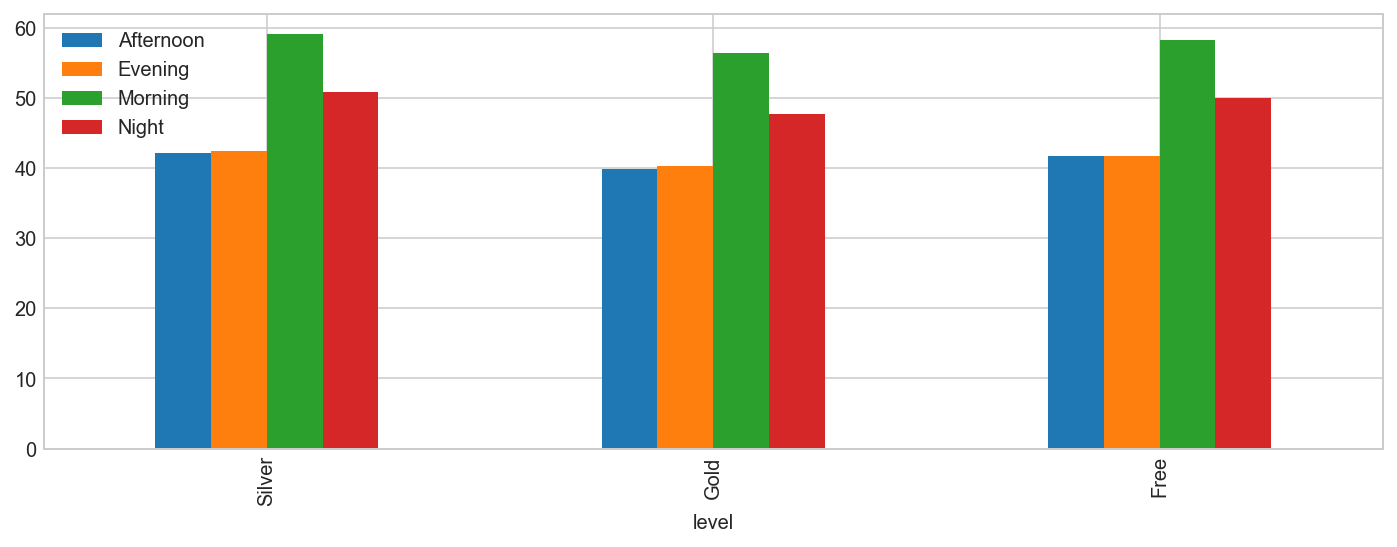

In [30]:
result_df.toPandas().plot.bar(x='level', figsize=(12, 4));

In [31]:
result_df.unpersist()

DataFrame[level: string, Afternoon: double, Evening: double, Morning: double, Night: double]

### 4.4 Distribution of Customers By Level:

In [32]:
result_df = (cust_df.select(['level', (F.when(col('gender') == 0, "Male").otherwise("Female")).alias('gender')])
                 .groupBy('level')
                 .pivot('gender')
                 .count()
                 .orderBy('level', ascending=False))

In [33]:
result_df.cache().show()

+-----+------+----+
|level|Female|Male|
+-----+------+----+
|    2|   201| 330|
|    1|   670| 971|
|    0|  1145|1683|
+-----+------+----+



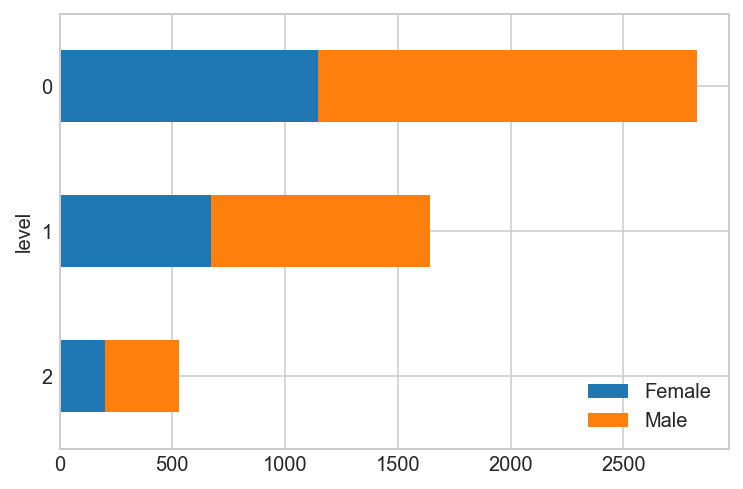

In [34]:
result_df.toPandas().set_index('level').plot.barh(stacked=True);

In [35]:
result_df.unpersist()

DataFrame[level: int, Female: bigint, Male: bigint]

### 4.4 Top 10 Zip Codes: Which regions consume most from this service:

In [36]:
result_df = cust_df.groupBy('zip').count().orderBy('count', ascending=False).limit(10)

In [37]:
result_df.cache().show()

+-----+-----+
|  zip|count|
+-----+-----+
| 5341|    4|
|80821|    4|
|71458|    3|
|31409|    3|
|70446|    3|
|20098|    3|
|80459|    3|
|57445|    3|
|78754|    3|
|47577|    3|
+-----+-----+



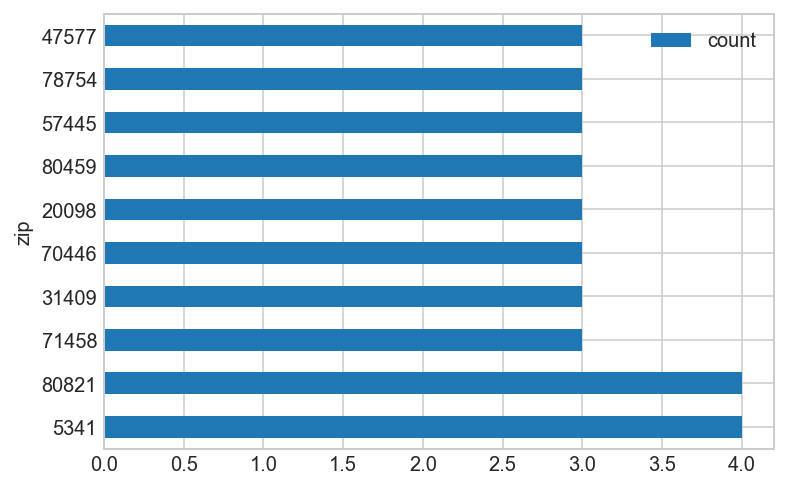

In [38]:
result_df.toPandas().plot.barh(x='zip');

In [39]:
result_df.unpersist()

DataFrame[zip: int, count: bigint]

### 4.5 Distribution of Customers By SignUp Campaign:

In [40]:
# Map from campaign number to actual campaign string
campaign_map = {0:"None", 1:"30DaysFree", 2:"SuperBowl",  3:"RetailStore", 4:"WebOffer"}

# Define a udf
udfIndexToCampaign = udf(lambda x: campaign_map[x], StringType())

In [41]:
result_df = (cust_df.select(udfIndexToCampaign("campaign").alias("campaign"))
                 .groupBy('campaign')
                 .count()
                 .orderBy('count', ascending=True))

In [42]:
result_df.cache().show()

+-----------+-----+
|   campaign|count|
+-----------+-----+
|  SuperBowl|  240|
|RetailStore|  489|
|       None|  608|
|   WebOffer|  750|
| 30DaysFree| 2913|
+-----------+-----+



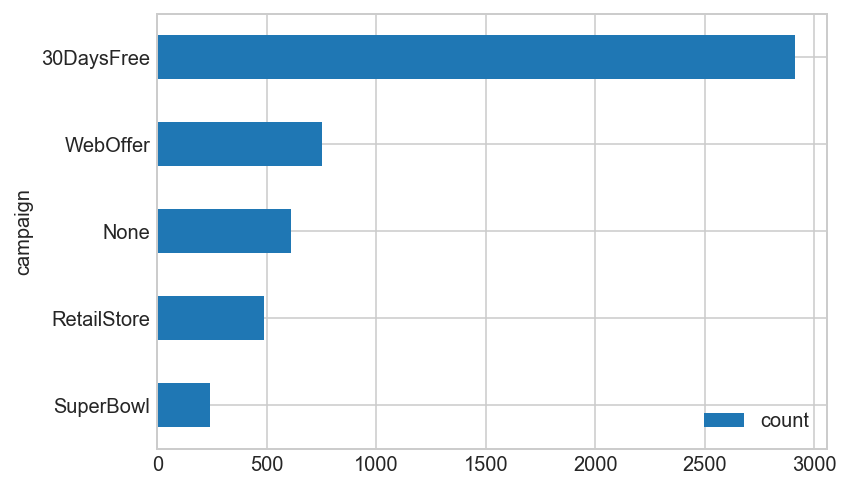

In [43]:
result_df.toPandas().plot.barh(x='campaign');

In [44]:
result_df.unpersist()

DataFrame[campaign: string, count: bigint]

### 4.6 Average Unique Track Count By Customer Level:

In [45]:
result_df = (music_df.select(['customer_id', 'track_id'])
                            .groupBy('customer_id')
                            .agg(F.countDistinct('track_id').alias('unique_track_count'))
                            .join(cust_df, on='customer_id', how='inner')
                            .select([udfIndexTolevel('level').alias('level'), 'unique_track_count'])
                            .groupBy('level')
                            .agg(F.avg('unique_track_count').alias('avg_unique_track_count')))

In [46]:
result_df.cache().show()

+------+----------------------+
| level|avg_unique_track_count|
+------+----------------------+
|Silver|     170.2772699573431|
|  Gold|    166.85310734463278|
|  Free|     170.9515558698727|
+------+----------------------+



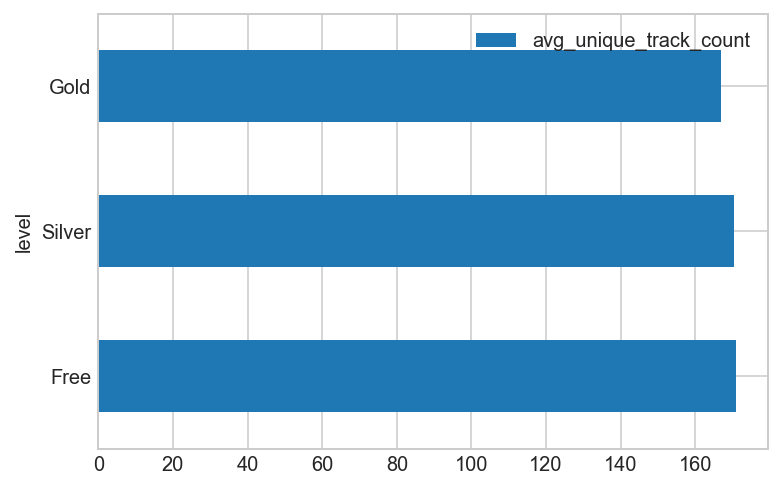

In [47]:
result_df.toPandas().sort_values(by='avg_unique_track_count', ascending=False).plot.barh(x='level');

In [48]:
result_df.unpersist()

DataFrame[level: string, avg_unique_track_count: double]

### 4.7 Mobile Tracks Count By Customer Level:

In [49]:
result_df = (music_df.select(['customer_id', 'track_id'])
                            .filter(col('is_mobile') == 1)
                            .groupBy('customer_id')
                            .count()
                            .withColumnRenamed('count', 'mobile_track_count')
                            .join(cust_df, on='customer_id', how='inner')
                            .select([udfIndexTolevel('level').alias('level'), 'mobile_track_count'])
                            .groupBy('level')
                            .agg(F.avg('mobile_track_count').alias('avg_mobile_track_count'))
                            .orderBy('avg_mobile_track_count'))

In [50]:
result_df.cache().show()

+------+----------------------+
| level|avg_mobile_track_count|
+------+----------------------+
|  Free|    100.01308345120226|
|Silver|     146.1614868982328|
|  Gold|    160.22033898305085|
+------+----------------------+



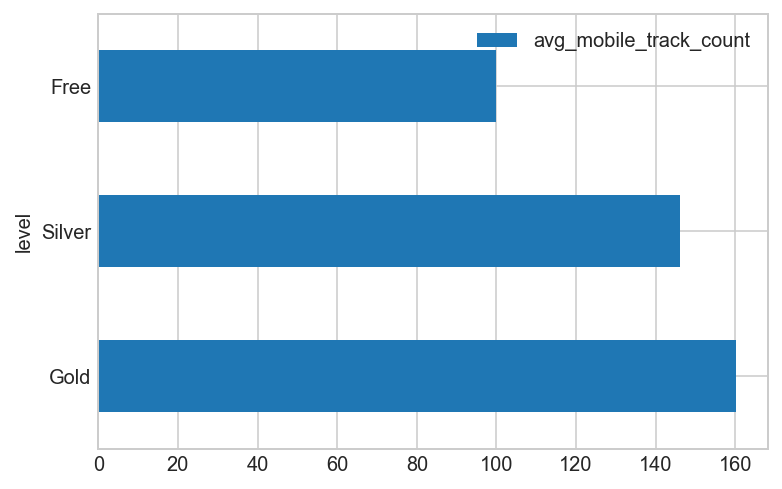

In [51]:
result_df.toPandas().sort_values(by='avg_mobile_track_count', ascending=False).plot.barh(x='level');

In [52]:
result_df.unpersist()

DataFrame[level: string, avg_mobile_track_count: double]

In [53]:
music_df.unpersist()
cust_df.unpersist()

DataFrame[customer_id: int, name: string, gender: int, address: string, zip: int, sign_date: string, status: int, level: int, campaign: int, lnkd_with_apps: int]

In [54]:
spark.stop()